**Kwaku Amo-Korankye - 10211100331<br>Class of 2025: Bachelor of Science in Artificial Intelligence<br>Multi-class Classification using ResNet18**

Installing dependencies

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import albumentations as A
from albumentations.pytorch import ToTensorV2
from PIL import Image
import copy
import time
import numpy as np
import pandas as pd
import random
import os


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')

Using device: cpu


Class Label Dictionary Definition

In [ ]:
import os

# Define dataset path
dataset_path = "/Users/academiccity/Documents/amokorankye/final models/dataset" 

# Define split ratios
train_ratio = 0.7
val_ratio = 0.15
test_ratio = 0.15

# Create an empty dictionary to store class labels
class_labels = {}
label_id = 0  # Start labeling from 0

# Scan the main dataset folder and assign numerical IDs to each class
for disease_folder in os.listdir(dataset_path):
    disease_path = os.path.join(dataset_path, disease_folder)
    
    # Only process directories
    if os.path.isdir(disease_path):
        for subfolder in os.listdir(disease_path):
            subfolder_path = os.path.join(disease_path, subfolder)
            # Optionally check if subfolder is also a directory
            if os.path.isdir(subfolder_path) and subfolder not in class_labels:
                class_labels[subfolder] = label_id
                label_id += 1  # Increment label ID

# Print the assigned class labels
print("Class Label Mapping:")
print(class_labels)


Class Label Mapping:
{'pituitary': 0, 'bone fractured': 1, 'healthy brain': 2, 'adenocarcinoma': 3, 'glioma': 4, 'benign': 5, 'breast cancer positive': 6, 'bone not fractured': 7, 'squamous cell carcinoma': 8, 'meningioma': 9, 'breast cancer negative': 10}


Data Transformations to ensure uniformity

In [31]:
import torch
from torch.utils.data import Dataset
from torchvision import transforms
from PIL import Image

class MedicalDataset(Dataset):
    def __init__(self, dataset_path, class_labels, transform=None):
        self.image_paths = []
        self.labels = []
        self.transform = transform  

        # print(f"Dataset initialized with transform: {type(self.transform)}")  

        for disease_folder in os.listdir(dataset_path):  
            disease_path = os.path.join(dataset_path, disease_folder)

            for subcategory in os.listdir(disease_path):  
                subcategory_path = os.path.join(disease_path, subcategory)

                for img_name in os.listdir(subcategory_path):
                    img_path = os.path.join(subcategory_path, img_name)
                    self.image_paths.append(img_path)
                    self.labels.append(class_labels[subcategory])

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        try:
            image = Image.open(self.image_paths[idx]).convert("RGB")  
        except Exception as e:
            print(f"Skipping corrupted file: {self.image_paths[idx]} - Error: {e}")
            return None, None

        label = self.labels[idx]

        if self.transform is not None:
            image = self.transform(image)  

        return image, label


In [ ]:
# Define transformations
data_transforms = {
    "train": transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5], std=[0.5])
    ]),
    "val": transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5], std=[0.5])
    ])
}

# Load dataset correctly
train_dataset = MedicalDataset(dataset_path, class_labels, transform=data_transforms["train"])
val_dataset = MedicalDataset(dataset_path, class_labels, transform=data_transforms["val"])
test_dataset = MedicalDataset(dataset_path, class_labels, transform=data_transforms["val"])


Training. Testing and Validation Split

In [ ]:
from torch.utils.data import random_split

# Load the full dataset correctly (Apply only ONE transform, not the whole dictionary)
full_dataset = MedicalDataset(dataset_path, class_labels, transform=data_transforms["train"])

# Define dataset split sizes
train_size = int(0.7 * len(full_dataset))
val_size = int(0.15 * len(full_dataset))
test_size = len(full_dataset) - train_size - val_size  # Ensure total size remains consistent

# Split the dataset
train_dataset, val_dataset, test_dataset = random_split(full_dataset, [train_size, val_size, test_size])

# Reassign correct transforms for val and test sets
val_dataset.dataset.transform = data_transforms["val"]
test_dataset.dataset.transform = data_transforms["val"]

# Print dataset sizes

print(f"Full Dataset: {len(full_dataset)}")

print(f"Training Samples: {len(train_dataset)}")
print(f"Validation Samples: {len(val_dataset)}")
print(f"Test Samples: {len(test_dataset)}")


Training Samples: 20934
Validation Samples: 4486
Test Samples: 4487


In [ ]:
from torch.utils.data import DataLoader

# Define batch size
batch_size = 32
def collate_fn(batch):
    batch = [b for b in batch if b[0] is not None]  # Remove None values
    return torch.utils.data.default_collate(batch)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, collate_fn=collate_fn)

In [37]:
# Get one batch of images and labels
images, labels = next(iter(train_loader))

# Print batch details
print("Batch shape:", images.shape)  # (Batch Size, Channels, Height, Width)
print("Class IDs in this batch:", labels)


Batch shape: torch.Size([32, 3, 224, 224])
Class IDs in this batch: tensor([10,  4,  8,  3, 10,  9,  8,  3,  8,  5,  3,  5,  8,  5,  8,  5,  2,  5,
         6,  7,  8,  7,  9,  3,  7,  3,  5,  5,  6,  8,  5,  4])


Class Visualization

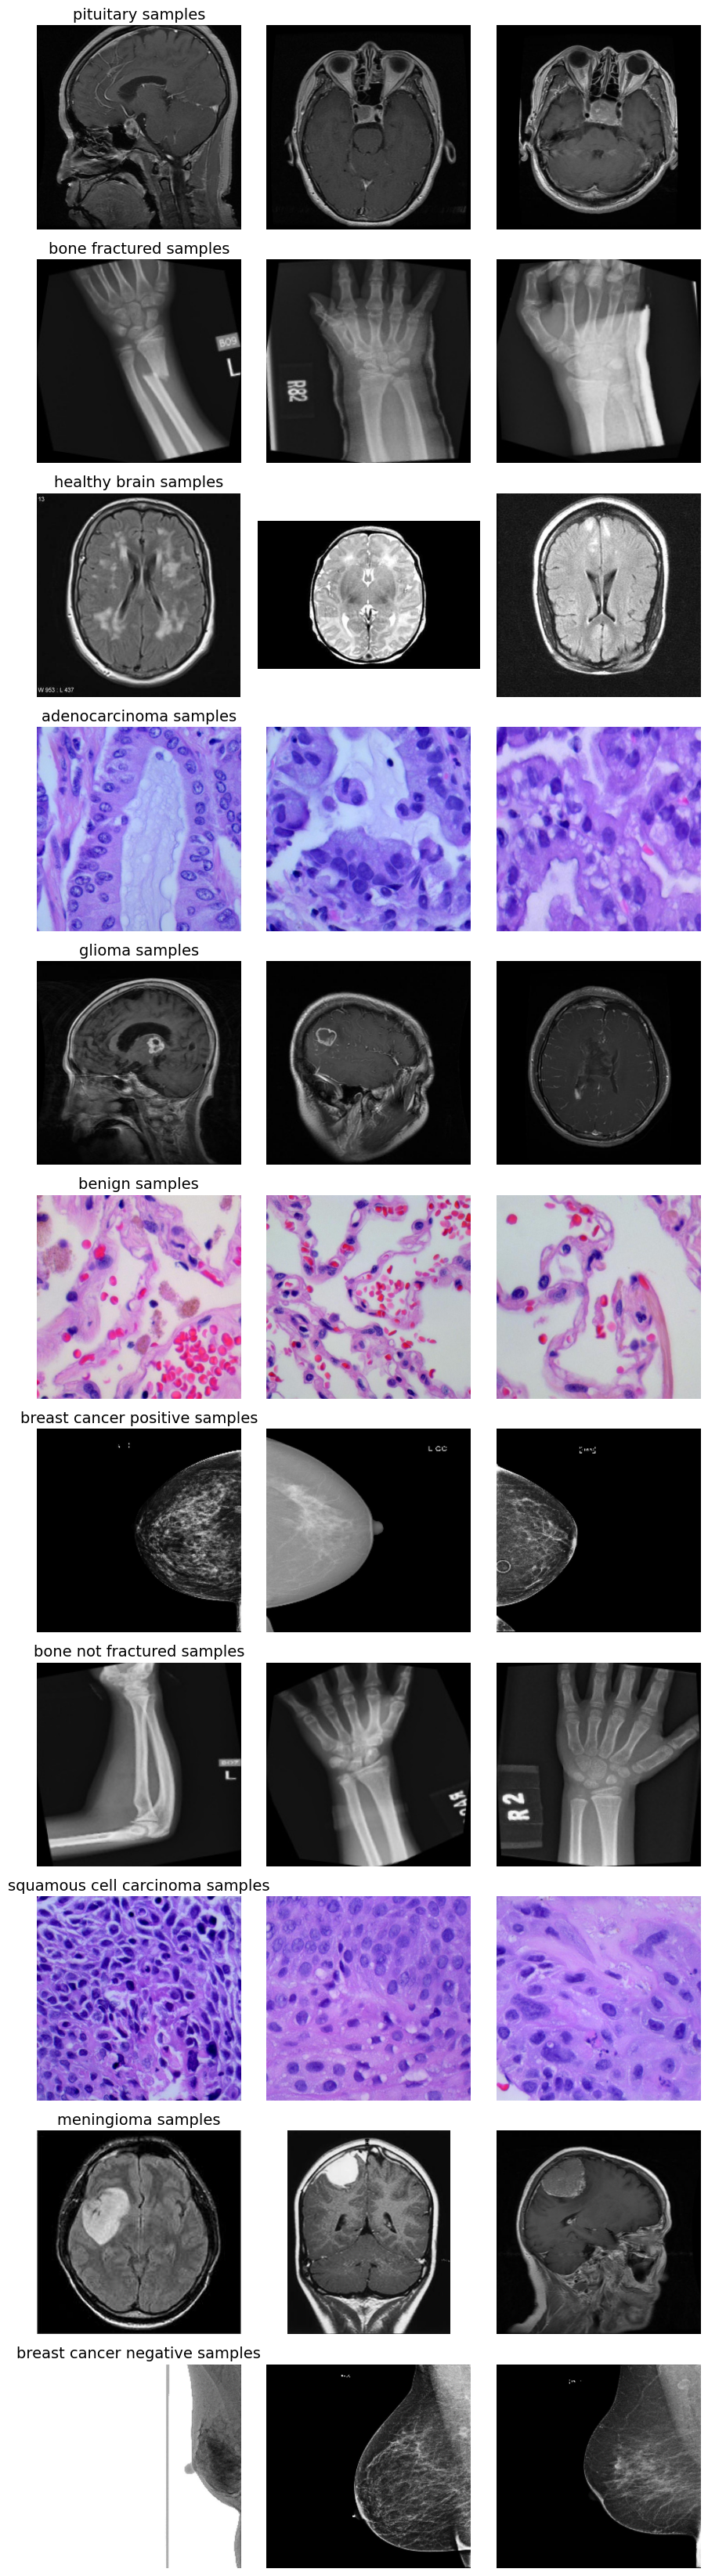

In [38]:
import os
import random
import matplotlib.pyplot as plt
from PIL import Image

def show_class_samples(dataset_path, class_labels, num_samples=3):
    """
    Displays sample images from each class in the dataset.

    Parameters:
    - dataset_path (str): Path to the dataset directory.
    - class_labels (dict): Dictionary mapping class names to numerical labels.
    - num_samples (int): Number of samples to display per class.
    """
    fig, axes = plt.subplots(len(class_labels), num_samples, figsize=(num_samples * 3, len(class_labels) * 3))

    for i, (cls_name, cls_id) in enumerate(class_labels.items()):
        class_found = False
        class_dir = None

        # Find the subfolder for the class
        for disease_folder in os.listdir(dataset_path):
            disease_path = os.path.join(dataset_path, disease_folder)
            potential_class_dir = os.path.join(disease_path, cls_name)
            if os.path.exists(potential_class_dir):  # Check if class folder exists
                class_dir = potential_class_dir
                class_found = True
                break

        if not class_found:
            print(f"Warning: Class folder for '{cls_name}' not found!")
            continue

        # Get random images from the class folder
        images = random.sample(os.listdir(class_dir), min(num_samples, len(os.listdir(class_dir))))
        
        for j, img_name in enumerate(images):
            img_path = os.path.join(class_dir, img_name)
            img = Image.open(img_path)

            if len(class_labels) == 1:  # Handle single-class case
                axes[j].imshow(img)
                axes[j].axis("off")
                axes[j].set_title(f"{cls_name} samples", fontsize=14)
            else:
                axes[i, j].imshow(img)
                axes[i, j].axis("off")
                if j == 0:
                    axes[i, j].set_title(f"{cls_name} samples", fontsize=14)

    plt.tight_layout()
    plt.show()

# Call function with the updated dataset path and class labels
show_class_samples(dataset_path, class_labels)


Model Architecture (ResNet18)

In [39]:
import torch
import torch.nn as nn
import torchvision.models as models

# Define the number of classes based on dataset
num_classes = len(class_labels)  # Automatically count classes

# Load ResNet-18 (pretrained on ImageNet)
model = models.resnet18(pretrained=True)

# Get the number of input features to the final layer
num_ftrs = model.fc.in_features

# Replace the final fully connected layer with a new one for our classification task
model.fc = nn.Linear(num_ftrs, num_classes)

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Print model summary
print(model)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

Training Setup

In [40]:
import time
import torch
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.nn as nn

# Define loss function, optimizer, and scheduler
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", factor=0.1, patience=5)

# Training loop function
def train_model(model, dataloaders, dataset_sizes, num_epochs=10):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    
    best_model_wts = model.state_dict()
    best_loss = float("inf")

    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}")
        print("-" * 30)

        for phase in ["train", "val"]:
            if phase == "train":
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == "train"):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == "train":
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f"{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")

            # Step learning rate scheduler based on validation loss
            if phase == "val":
                scheduler.step(epoch_loss)

            # Save best model
            if phase == "val" and epoch_loss < best_loss:
                best_loss = epoch_loss
                best_model_wts = model.state_dict()

    print("Training complete!")
    model.load_state_dict(best_model_wts)
    return model


Training Loop

In [41]:
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=25):
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    history = {'train_loss': [], 'val_loss': [], 'val_acc': []}

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        model.train()
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        val_loss, val_acc = evaluate_model(model, val_loader, criterion)
        scheduler.step(val_loss)

        print(f"Train Loss: {running_loss/len(train_loader)}, Val Loss: {val_loss}, Val Acc: {val_acc}")

        history['train_loss'].append(running_loss/len(train_loader))
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)

        if val_acc > best_acc:
            best_acc = val_acc
            best_model_wts = copy.deepcopy(model.state_dict())

    model.load_state_dict(best_model_wts)
    return model, history

def evaluate_model(model, data_loader, criterion):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    return running_loss / len(data_loader), 100 * correct / total

Model Training

In [42]:
# Training the model
trained_model, history = train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=20)


Epoch 1/20
Train Loss: 0.3906029667221863, Val Loss: 0.25847254317016044, Val Acc: 89.45608559964333
Epoch 2/20
Train Loss: 0.232487800225388, Val Loss: 0.2771133860797747, Val Acc: 87.82880071333037
Epoch 3/20
Train Loss: 0.17804460631299565, Val Loss: 0.34651959565937096, Val Acc: 87.22692822113241
Epoch 4/20
Train Loss: 0.15529441279821268, Val Loss: 0.15076316890458688, Val Acc: 93.37940258582256
Epoch 5/20
Train Loss: 0.12632633881707397, Val Loss: 0.12938463218272367, Val Acc: 93.82523406152474
Epoch 6/20
Train Loss: 0.12021434744784452, Val Loss: 0.21956266741539146, Val Acc: 92.2871154703522
Epoch 7/20
Train Loss: 0.13870797710642502, Val Loss: 0.10829331090753065, Val Acc: 95.07356219349086
Epoch 8/20
Train Loss: 0.101108912102352, Val Loss: 0.11266320646261212, Val Acc: 94.9398127507802
Epoch 9/20
Train Loss: 0.10102199779731001, Val Loss: 0.13775120695833287, Val Acc: 93.60231832367366
Epoch 10/20
Train Loss: 0.10080436079483834, Val Loss: 0.160596060665681, Val Acc: 93.1341

Evaluating the Model on the Test Set

In [43]:
test_loss, test_acc = evaluate_model(model, test_loader, criterion)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_acc}%")

Test Loss: 0.1354045322147761, Test Accuracy: 95.89926454201026%


Training and Validation Metrics for Model Comparison

Keys in history: dict_keys(['train_loss', 'val_loss', 'val_acc'])


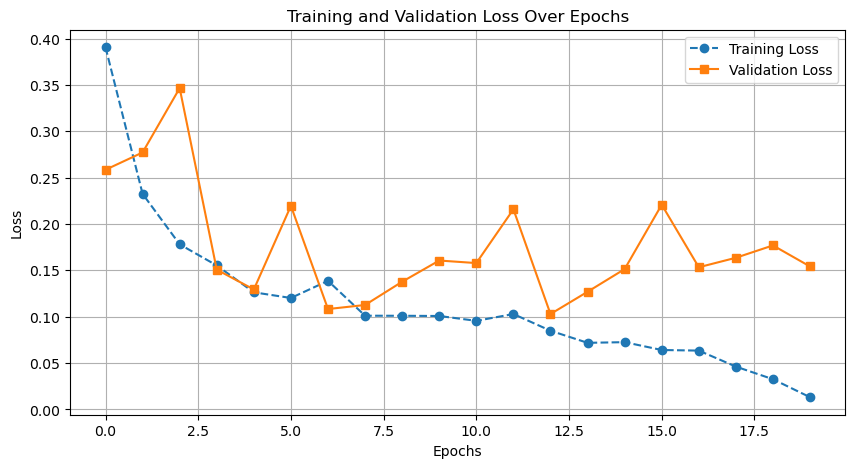

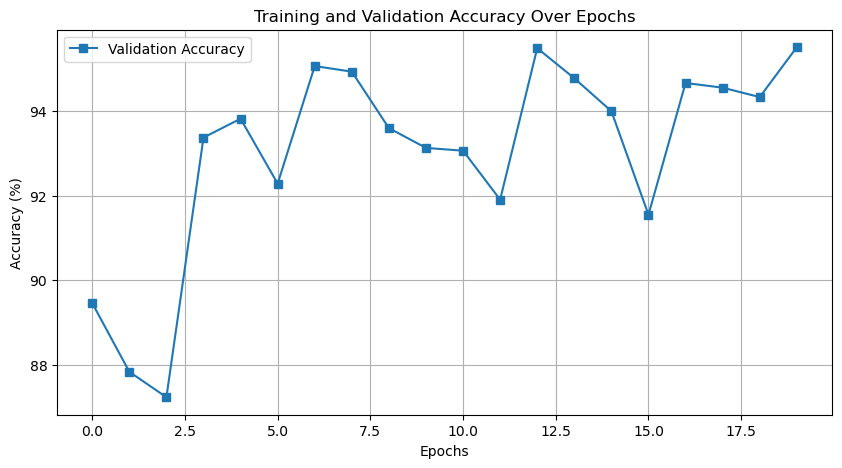

In [ ]:
import matplotlib.pyplot as plt

# Check if history dictionary has expected keys before plotting
print("Keys in history:", history.keys())

# Training and Validation Loss Plot
plt.figure(figsize=(10, 5))
plt.plot(history['train_loss'], label='Training Loss', marker='o', linestyle='dashed')
plt.plot(history['val_loss'], label='Validation Loss', marker='s', linestyle='solid')
plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Training and Validation Accuracy Plot
plt.figure(figsize=(10, 5))

# Check if train_acc exists before plotting
if 'train_acc' in history:
    plt.plot(history['train_acc'], label='Training Accuracy', marker='o', linestyle='dashed')

plt.plot(history['val_acc'], label='Validation Accuracy', marker='s', linestyle='solid')
plt.title('Training and Validation Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)
plt.show()


Confusion Matrix and Classification Report

In [45]:
import torch
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(model, data_loader, class_labels):
    """
    Generates a confusion matrix for the given model and dataset.

    Parameters:
    - model: Trained PyTorch model
    - data_loader: DataLoader for the test/validation set
    - class_labels: List of class names corresponding to class indices
    """
    model.eval()
    all_preds = []
    all_labels = []
    
    # Disable gradient computation for faster inference
    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            # Convert tensors to lists for compatibility
            all_preds.extend(preds.cpu().tolist())
            all_labels.extend(labels.cpu().tolist())

    # Compute confusion matrix
    cm = confusion_matrix(all_labels, all_preds)

    # Plot the confusion matrix using Seaborn
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
    
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.xticks(rotation=45)  # Rotate labels for better visibility
    plt.yticks(rotation=45)
    plt.show()

    return all_preds, all_labels


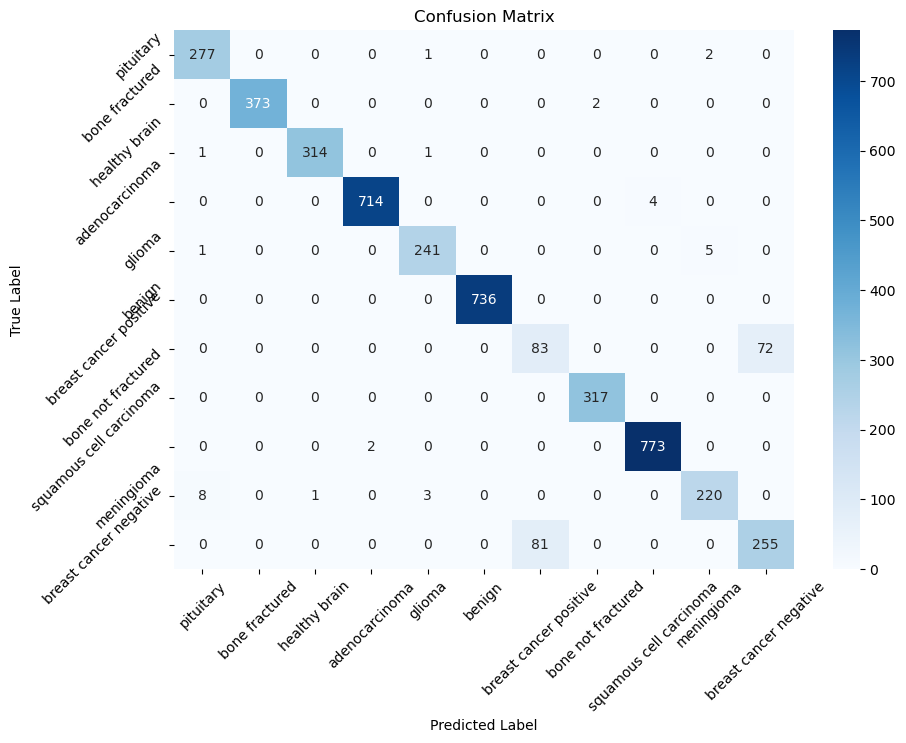

([5,
  4,
  8,
  5,
  4,
  7,
  7,
  3,
  8,
  5,
  3,
  8,
  8,
  1,
  1,
  10,
  8,
  8,
  3,
  5,
  10,
  2,
  9,
  3,
  10,
  8,
  0,
  5,
  7,
  7,
  2,
  3,
  0,
  3,
  4,
  2,
  8,
  3,
  1,
  5,
  3,
  10,
  4,
  5,
  3,
  5,
  10,
  8,
  3,
  10,
  7,
  7,
  5,
  2,
  0,
  8,
  10,
  5,
  5,
  5,
  2,
  4,
  4,
  8,
  5,
  5,
  2,
  9,
  2,
  0,
  1,
  2,
  7,
  6,
  1,
  8,
  3,
  5,
  8,
  5,
  1,
  8,
  3,
  3,
  3,
  0,
  4,
  7,
  8,
  3,
  5,
  5,
  1,
  5,
  5,
  8,
  5,
  3,
  3,
  3,
  5,
  10,
  8,
  5,
  7,
  10,
  3,
  1,
  8,
  8,
  9,
  3,
  8,
  4,
  8,
  7,
  4,
  8,
  7,
  9,
  3,
  5,
  3,
  10,
  8,
  6,
  5,
  7,
  5,
  3,
  8,
  5,
  8,
  10,
  3,
  3,
  1,
  5,
  5,
  3,
  8,
  9,
  4,
  4,
  8,
  3,
  8,
  9,
  2,
  10,
  4,
  0,
  9,
  5,
  10,
  4,
  2,
  2,
  1,
  5,
  5,
  5,
  5,
  3,
  5,
  7,
  10,
  3,
  8,
  8,
  9,
  5,
  3,
  10,
  5,
  9,
  9,
  8,
  8,
  8,
  9,
  8,
  10,
  5,
  8,
  3,
  1,
  5,
  5,
  7,
  3,
  8,
  9,
  5,
  6,
  6,
  8,

In [46]:
# Define class names from your dataset
class_names = list(class_labels.keys())  # Get class labels in correct order

# Plot confusion matrix using test data
plot_confusion_matrix(model, test_loader, class_names)


In [47]:
def plot_confusion_matrix(model, data_loader, class_labels):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.cpu().tolist())
            all_labels.extend(labels.cpu().tolist())

    # Print unique values in predictions and labels
    print("Unique predicted classes:", set(all_preds))
    print("Unique actual classes:", set(all_labels))

    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
    
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.xticks(rotation=45)
    plt.yticks(rotation=45)
    plt.show()

    return all_preds, all_labels


Saving The Model

In [48]:
model_path = '/Users/academiccity/Documents/amokorankye/final models/comprehensive_model.pth'
torch.save(model, "comprehensive_model.pth")
print(f'Model saved at {model_path}')

Model saved at /Users/academiccity/Documents/amokorankye/final models/comprehensive_model.pth
